In [50]:
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR


import os
import numpy as np

from models.stage1_vocaset import VQAutoEncoder
from metrics.loss import calc_vq_loss
from base.utilities import AverageMeter
import wandb
from funciones import IntraDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
torch.manual_seed(12)
np.random.seed(12)

cuda


In [51]:
class Args:
    def __init__(self):
        # LOSS settings
        self.quant_loss_weight = 1.

        # NETWORK settings
        #self.arch = 'stage1_vocaset'
        self.in_dim = 39
        self.hidden_size = 1024
        self.num_hidden_layers = 6
        self.num_attention_heads = 8
        self.intermediate_size = 1536
        self.window_size = 1
        self.quant_factor = 0
        self.face_quan_num = 16
        self.neg = 0.2
        self.INaffine = False

        # VQuantizer settings
        self.n_embed = 256
        self.zquant_dim = 64#64

        # TRAIN settings
        self.use_sgd = False
        self.sync_bn = False  # adopt sync_bn or not
        self.train_gpu = [0]
        self.workers = 10  # data loader workers
        self.batch_size = 1  # batch size for training
        self.batch_size_val = 1  # batch size for validation during training
        self.base_lr = 0.0001
        self.StepLR = True
        self.warmup_steps = 1
        self.adaptive_lr = False
        self.factor = 0.3
        self.patience = 3
        self.threshold = 0.0001
        self.poly_lr = False
        self.epochs = 200
        self.step_size = 200
        self.gamma = 0.9
        self.start_epoch = 0
        self.power = 0.9
        self.momentum = 0.9
        self.weight_decay = 0.002
        self.manual_seed = 131

        ##stage 2
        self.device = 'cuda'  # or 'cpu'
        self.dataset = 'BIWI'  # or 'multi' depending on your dataset
        self.wav2vec2model_path = 'path/to/wav2vec2model'  # path to pretrained Wav2Vec2 model
        self.feature_dim = 1024  # dimension for the feature after audio encoding
        self.vertice_dim = 31  # number of vertices * 3 (e.g., V * 3 for 3D coordinates)
        self.n_head = 8  # number of attention heads in the transformer decoder
        self.num_layers = 6  # number of layers in the transformer decoder
        self.period = 2#100  # period for positional encoding
        #self.face_quan_num = 16  # quantization levels per face/vertex
        #self.zquant_dim = 64  # dimension of the quantized latent space
        self.vqvae_pretrained_path = 'modelos-entrenados/fast-bee.pth'  # path to pretrained VQ-VAE
        self.train_subjects = 'subject1 subject2 subject3'  # space-separated list of subjects used in training
        self.motion_weight = 1.0  # weight for the motion loss
        self.reg_weight = 0.1  # weight for the regularization loss
        self.batch_size = 1#32  # batch size for training
        #self.epochs = 100  # number of training epochs
        #self.base_lr = 0.0001  # base learning rate
        self.gpu = torch.cuda.current_device()

# Instantiate the arguments
args = Args()


In [52]:
# Usage
#intra_dataset = IntraDataset(INTRA_FOLDER, mode="pre_order")
#intra_dataset = IntraDataset(INTRA_FOLDER, mode="pre_order")
#data_loader = DataLoader(intra_dataset, batch_size=1, shuffle=True)

#dataset de validacion
INTRA_FOLDER = "p15/train/"

val_dataset = IntraDataset("p20+originales/val/", mode = "post_order", train = True, fn=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True)

file list ['0070.npy', '0070_01.npy', '0070_02.npy', '0071.npy', '0071_01.npy', '0071_02.npy', '0073.npy', '0073_01.npy', '0073_02.npy', '0074a.npy', '0074a_01.npy', '0074a_02.npy', '0074b.npy', '0074b_01.npy', '0074b_02.npy', '0076.npy', '0076_01.npy', '0076_02.npy', '0077.npy', '0077_01.npy', '0077_02.npy', '0078.npy', '0078_01.npy', '0078_02.npy', '0079.npy', '0079_01.npy', '0079_02.npy', '0080.npy', '0080_01.npy', '0080_02.npy', '0081.npy', '0081_01.npy', '0081_02.npy', '0082.npy', '0082_01.npy', '0082_02.npy', '0083.npy', '0083_01.npy', '0083_02.npy', '0084.npy', '0084_01.npy', '0084_02.npy', 'rot1-0070.npy', 'rot1-0070_01.npy', 'rot1-0070_02.npy', 'rot1-0071.npy', 'rot1-0071_01.npy', 'rot1-0071_02.npy', 'rot1-0073.npy', 'rot1-0073_01.npy', 'rot1-0073_02.npy', 'rot1-0074a.npy', 'rot1-0074a_01.npy', 'rot1-0074a_02.npy', 'rot1-0074b.npy', 'rot1-0074b_01.npy', 'rot1-0074b_02.npy', 'rot1-0076.npy', 'rot1-0076_01.npy', 'rot1-0076_02.npy', 'rot1-0077.npy', 'rot1-0077_01.npy', 'rot1-0077

In [53]:
#checkpoint = torch.load("modelos-entrenados/grateful-field-preorder.pth")
#checkpoint = torch.load("modelos-entrenados/aneurisk-splines-final.pth")

checkpoint = torch.load("modelos-entrenados/aneurisk-limpio-splines.pth")

#checkpoint = torch.load("modelos-entrenados/elated-surf.pth", map_location= "cuda:0")
model = VQAutoEncoder(args).to(device)
model.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epoch'] + 1
best_loss = checkpoint['loss']
print(checkpoint['epoch'])
# Now you can continue training from this point or use the model for inference

/tmp/ipykernel_7120/1072978218.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("modelos-entrenados/aneurisk-limpio-splines.pth")


219


In [54]:
arboles_generados = {}
for input, file_name in val_loader:
    with torch.no_grad():  # No need to compute gradients during sampling
        #input = input.reshape(-1,39)
        generated_tree, quantized_tree = model.sample_step(input.to(device))
        arboles_generados[file_name] = generated_tree


In [55]:
from collections import defaultdict
from funciones import Tree

def deserialize_post_order(serial):

    serial = serial.copy()

    def post_order(serial):

        if serial[-39:] == list([0.0] * 39):
            for i in range(39): serial.pop()
            return None
        
        data = defaultdict(list)
        for i in range(39):
            data["r"].append(serial.pop())
       

        tree = Tree(data)

        tree.right = post_order(serial)
        tree.left = post_order(serial)
        
        return tree    
    
    return post_order(serial)

def deserialize_pre_order(serial):
    
    #serial = serial.copy()
    if  not serial:
        return 
    nodes = serial.split(';') 
    def post(serial):
        if len(serial) > 0:
            dat = serial[0].split("_")[1]
            if dat != str([0.0] * 39):
                data = defaultdict(list)
                g = dat.split(",")
                g [0] = g[0].replace('[','')
                g[-1] = g[-1].replace(']','')
                for i in range(39):
                    data["r"].append(g.pop(0))
                
                tree = Tree(data)

                left, ret = post(serial[1:])
                right, ret = post(ret)

                tree.left = left
                tree.right = right

                return tree, ret

            else:
                return None, serial[1:]
            
        #else:
        #    return None, []
    return post(nodes)

def serialize_post_order(tree):

    def post_order(tree):

        if tree:

            post_order(tree.left)
            post_order(tree.right)

            #ret[0] += '1_'+ str([np.round(float(v), 39) for v in list(tree.data.values())]) +';'
            ret[0] += '1_'+ str(list(map(float, list(tree.data.values())[0]))) +';'

        else:
            ret[0] += '#;'

    ret = ['']
    post_order(tree)
    return ret[0][:-1]

def serialize_post_order_numpy_vector(tree):
    features = []

    def post_order(node):
        if node:
            post_order(node.left)
            post_order(node.right)
            features.append(list(map(float, list(node.data.values())[0])))  # Convert to float list and append
        else:
            features.append([0.0] * 39)

    post_order(tree)
    
    return np.array(features, dtype=np.float32)  # Convert to NumPy array

def serialize_pre_order(tree):

    if tree == None: return [[0.0] * 39]
    return list(tree.data.values())[::-1] + serialize_pre_order(tree.left) + serialize_pre_order(tree.right)

In [56]:
for file_name, generated_tree in arboles_generados.items():
    generado = generated_tree.cpu().detach().numpy()[0]
    #generado[generado<1e-2] = 0
    #for i, row in enumerate(generado):
    #    if np.mean(row)<0.1:
    #        generado[i] = [0.]*39
    generado [abs(generado)<1e-2] = 0
    #np.save("reconstruidos-val-augmented/"+file_name[0], np.array(generado))
    np.save("generadas-p20-orig/"+file_name[0], np.array(generado))
    serializado = ''
    j = 0
    try:
        for array in generado :
            #print(np.mean(array))
            if (np.mean(array)<0.1):
                #string = "#;"
                string = str(00)+"_"+str([0.]*39)+";"
            else:
                string = str(j)+"_"+str([float(val) for val in array])+";"
            serializado += string
            j+=1
        serializado = serializado[:-1]
        tree, ret = deserialize_pre_order(serializado)
        vec = serialize_post_order_numpy_vector(tree)
        #vec = vec[:, ::-1]
        #np.save("reconstruidos-train-augmented/"+file_name[0], np.array(vec))
    except:
        print(f"no compila {file_name[0]}")

In [57]:
generado[0]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.03501718,
        0.02326792, -0.04787245, -0.02545769,  0.        ,  0.03584064,
        0.02387888, -0.04453178, -0.03089869,  0.0415077 ,  0.04186204,
       -0.03128185, -0.04430676, -0.03220083,  0.04082472,  0.02263321,
       -0.03056351, -0.07306974,  0.02289887,  0.06465793,  0.02529987,
       -0.03085655, -0.07187156, -0.51451916, -0.25630578, -0.12992808,
        0.        ,  0.24001126,  0.48638365,  0.747919  ,  0.8720092 ,
        1.0014046 ,  1.2418499 ,  1.4893733 ,  1.7478702 ], dtype=float32)

In [58]:
p

array([32.62120056, 20.02560043, 25.07920074, ...,  0.        ,
        0.        ,  0.        ])

In [59]:
np.load("p20/train/0002-01.npy")

FileNotFoundError: [Errno 2] No such file or directory: 'p20/train/0002-01.npy'

before [[ 0.          0.          0.         ...  1.2460791   1.4588193
   1.697244  ]
 [-0.02087024  0.01213938  0.02659181 ...  1.1950651   1.3638933
   1.6515139 ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.3874753  -0.34317747 -0.30122477 ...  1.2133101   1.3230604
   1.4460949 ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
all tck []
shape (101, 39)
knots (101, 12)
coefs (101, 24)
numeor de nodos no nulos 47


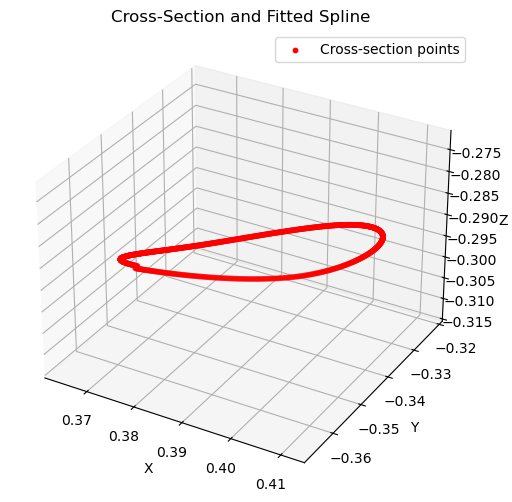

cantidad de splines 50


In [ ]:
from plotsplines import read_vtp, evaluate_splines, create_vtk_polydata, visualize_vtk_polydata


In [ ]:
generado = generated_tree.cpu().detach().numpy()[0]
#generado[generado<1e-2] = 0
for i, row in enumerate(generado):
    if np.mean(row)<0.1:
        generado[i] = [0.]*39

serializado = ''
j = 0
for array in generado :
    #print(np.mean(array))
    if (np.mean(array)<0.1):
        #string = "#;"
        string = str(00)+"_"+str([0.]*39)+";"
    else:
        string = str(j)+"_"+str([float(val) for val in array])+";"
    serializado += string
    j+=1
serializado = serializado[:-1]

tree, ret = deserialize_pre_order(serializado)
print(tree.data)
#serial_tree = serialize_post_order(tree)
#print("ser", serial_tree)
#vector = []
#traversefeaturesSerializado(tree, vector)
#data_np = np.array(vector).reshape((-1,39))
vec = serialize_post_order_numpy_vector(tree)
vec = vec[:, ::-1]
np.save("reconstruido.npy", np.array(vec))


defaultdict(<class 'list'>, {'r': ['-0.01074302475899458', ' 0.00574408657848835', ' 0.00019808753859251738', ' 0.009811926633119583', ' -0.03305951505899429', ' -0.023305721580982208', ' 0.013699141331017017', ' 0.02430642768740654', ' 0.009439384564757347', ' -0.033090606331825256', ' -0.02281133085489273', ' 0.03266060724854469', ' 0.023814279586076736', ' -0.01892140507698059', ' -0.008226865902543068', ' 0.014474482275545597', ' 0.03297243267297745', ' 0.0240224227309227', ' -0.01910041831433773', ' -0.010399946942925453', ' -0.007970974780619144', ' 0.005939126014709473', ' 0.0023800977505743504', ' -0.002726015169173479', ' -0.011536521837115288', ' -0.007668419741094112', ' 0.005535256117582321', ' -0.5419816374778748', ' -0.3963373601436615', ' -0.2598550021648407', ' -0.0006920970045030117', ' 0.2283947914838791', ' 0.4638946056365967', ' 0.6093636155128479', ' 0.7491593360900879', ' 1.0093179941177368', ' 1.2363941669464111', ' 1.4764692783355713', ' 1.619744896888733']})


In [ ]:
vec.shape

(7, 39)

In [ ]:
input

tensor([[[ 0.0000,  0.0000,  0.0000,  ...,  1.2334,  1.4942,  1.6136],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0197, -0.0083, -0.1449,  ...,  1.2591,  1.4625,  1.6965],
         ...,
         [-0.1502,  0.4790, -0.0201,  ...,  1.1196,  1.2601,  1.5242],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]])

In [ ]:
vec

array([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
       

In [ ]:
def traversefeaturesSerializado(root, features):
    def post_order(root, features):
        if root:
            post_order(root.left, features)
            post_order(root.right, features)
            features.append(root.data['r'])
                
        #else:
        #    features.append(torch.tensor([0.,0.,0.,0.]))           

    post_order(root, features)
    return features[:-1]  # remove last ,


In [ ]:
original = input.cpu().detach().numpy()[0]
print(np.array(original))
#np.save("original.npy", np.array(original))
serializado = ''
j = 0
for array in original :
    #print(np.mean(array))
    if (np.mean(array)== 0):
        #string = "#;"
        string = str(00)+"_"+str([0.]*39)+";"
    else:
        string = str(j)+"_"+str([float(val) for val in array])+";"
    serializado += string
    j+=1
serializado = serializado[:-1]

tree, ret = deserialize_pre_order(serializado)
print(tree.data)
#serial_tree = serialize_post_order(tree)
#print("ser", serial_tree)
#vector = []
#traversefeaturesSerializado(tree, vector)
#data_np = np.array(vector).reshape((-1,39))
vec = serialize_post_order_numpy_vector(tree)
vec = vec[:, ::-1]
np.save("original.npy", np.array(vec))

#np_tree = np.array(serial_tree)

[[ 0.          0.          0.         ...  1.2333623   1.4941806
   1.6135805 ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.01973928 -0.00826898 -0.14491902 ...  1.2591218   1.4625444
   1.6965077 ]
 ...
 [-0.15016943  0.4790075  -0.02012481 ...  1.119628    1.2601421
   1.524194  ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
defaultdict(<class 'list'>, {'r': ['0.0', ' 0.0', ' 0.0', ' 0.005129156168550253', ' -0.024278059601783752', ' -0.030098680406808853', ' 0.0017595381941646338', ' 0.015545717440545559', ' 0.005129156168550253', ' -0.024278059601783752', ' -0.030098680406808853', ' 0.002561163855716586', ' 0.019316069781780243', ' -0.02157910354435444', ' -0.030394749715924263', ' -0.015901507809758186', ' 0.002561163855716586', ' 0.019316069781780243', ' -0.02157910354435444', ' 0.0005554013187065721', ' -0.004405530635267496', ' -0.0028655908536

In [ ]:
vec.shape

(59, 39)

In [ ]:
d

NameError: name 'd' is not defined

In [ ]:
#paso el original de nuevo a post order y recien guardo


In [ ]:
def serialize_pre_order(tree):

    if tree == None: return [[0.0] * 39]
    return list(tree.data.values())[::-1] + serialize_pre_order(tree.left) + serialize_pre_order(tree.right)


#imito lo que hace el dataloader
file_path = os.path.join("aneuriskeps02-splines", "0023.npy")

# Use memory mapping to avoid loading full file into memory
tree_data_np = np.load(file_path, mmap_mode='r')
print(tree_data_np[10])
# Convert to tensor only when accessed
tree_tensor = torch.tensor(tree_data_np, dtype=torch.float32)
serial_tree = list(tree_tensor.flatten().numpy())
tree = deserialize_post_order(serial_tree)
serial_tree = serialize_pre_order(tree)
np_tree = np.array(serial_tree).reshape((-1,39))
tree_tensor = torch.tensor(np_tree, dtype = torch.float32)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
print(tree_data_np[28])


[10.13939953 35.30110168 37.37400055  9.37654833 10.4027289  10.85849191
 10.73082116 10.29803428  9.37654833 10.4027289  10.85849191 35.94593477
 34.36230673 35.15412011 35.67047434 35.93486407 35.94593477 34.36230673
 35.15412011 37.22818418 37.79091401 37.27563419 37.042192   37.01137175
 37.22818418 37.79091401 37.27563419 -0.69079989 -0.49687711 -0.27136601
  0.          0.14701132  0.30920011  0.50312289  0.72863399  1.
  1.14701132  1.30920011  1.50312289]


In [ ]:
vec[28]

array([ 1.5031229 ,  1.3092002 ,  1.1470113 ,  1.        ,  0.728634  ,
        0.50312287,  0.3092001 ,  0.14701131,  0.        , -0.271366  ,
       -0.4968771 , -0.6907999 , 37.275635  , 37.790913  , 37.228184  ,
       37.01137   , 37.04219   , 37.275635  , 37.790913  , 37.228184  ,
       35.15412   , 34.36231   , 35.945934  , 35.934864  , 35.670475  ,
       35.15412   , 34.36231   , 35.945934  , 10.858492  , 10.402729  ,
        9.376549  , 10.298035  , 10.730822  , 10.858492  , 10.402729  ,
        9.376549  , 37.374     , 35.3011    , 10.1394    ], dtype=float32)

In [ ]:
vec.shape

(119, 39)

In [ ]:
inverted_matrix = vec[:, ::-1]
inverted_matrix[28]

array([10.1394    , 35.3011    , 37.374     ,  9.376549  , 10.402729  ,
       10.858492  , 10.730822  , 10.298035  ,  9.376549  , 10.402729  ,
       10.858492  , 35.945934  , 34.36231   , 35.15412   , 35.670475  ,
       35.934864  , 35.945934  , 34.36231   , 35.15412   , 37.228184  ,
       37.790913  , 37.275635  , 37.04219   , 37.01137   , 37.228184  ,
       37.790913  , 37.275635  , -0.6907999 , -0.4968771 , -0.271366  ,
        0.        ,  0.14701131,  0.3092001 ,  0.50312287,  0.728634  ,
        1.        ,  1.1470113 ,  1.3092002 ,  1.5031229 ], dtype=float32)

In [ ]:
(vec-tree_data_np)[28]

array([-0.65181637,  0.02259827,  0.26686478,  0.00751444, -0.76691042,
       -0.91783524, -0.78332189, -0.30374679,  0.01853987, -0.75374113,
       -0.62802506,  0.47813368,  0.62708841,  0.00630699, -0.20869379,
       -0.00487521,  0.40888166,  0.58681284, -0.06428017,  0.52448611,
        0.31609588,  0.63323269,  0.61726998,  0.61233125,  0.51628832,
        0.09720092,  0.6363493 ,  0.03551185,  0.01456709,  0.15820164,
       -0.14192291,  0.02141976,  0.03615614,  0.05341003,  0.02659137,
       -0.00402635,  0.01159652,  0.06785994,  0.03147797])

In [ ]:
i=0
import traceback
for file_name, generated_tree in arboles_generados.items():
    i+=1
    generado = generated_tree.cpu().detach().numpy()[0]
    #generado[generado<1e-2] = 0
    for i, row in enumerate(generado):
        if np.mean(row)<0.1:
            generado[i] = [0.]*39

    serializado = ''
    j = 0
    try:
        for array in generado :
            #print(np.mean(array))
            if (np.mean(array)<0.1):
                #string = "#;"
                string = str(00)+"_"+str([0.]*39)+";"
            else:
                string = str(j)+"_"+str([float(val) for val in array])+";"
            serializado += string
            j+=1
        serializado = serializado[:-1]

        tree, ret = deserialize_pre_order(serializado)
        vec = serialize_post_order_numpy_vector(tree)
        vec = vec[:, ::-1]
        np.save(file_name[0], np.array(vec))
        # Use memory mapping to avoid loading full file into memory
        tree_data_np = np.load("stage1-augmented/train/"+ file_name[0], mmap_mode='r')
        print(tree_data_np[10])
        # Convert to tensor only when accessed
        tree_tensor = torch.tensor(tree_data_np, dtype=torch.float32)
        serial_tree = list(tree_tensor.flatten().numpy())
        tree = deserialize_post_order(serial_tree)
        serial_tree = serialize_pre_order(tree)
        np_tree = np.array(serial_tree).reshape((-1,39))
        tree_tensor = torch.tensor(np_tree, dtype = torch.float32)
    except:
        i+=1
        print(f"no compila {file_name[0]}")
        traceback.print_exc()
    if i>0:
        break

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
tree_data_np[-3]

memmap([-0.17415049, -0.10429844,  0.01452376, -0.19208889, -0.24207865,
        -0.16826656, -0.12843469, -0.12444527, -0.19208889, -0.24207865,
        -0.16826656, -0.0286907 , -0.04690212, -0.15743542, -0.1746936 ,
        -0.13729971, -0.0286907 , -0.04690212, -0.15743542, -0.07027163,
         0.08779504,  0.0911504 ,  0.01993336, -0.05459815, -0.07027163,
         0.08779504,  0.0911504 , -0.61922237, -0.50257209, -0.24670583,
         0.        ,  0.2557138 ,  0.38077763,  0.49742791,  0.75329417,
         1.        ,  1.2557138 ,  1.38077763,  1.49742791])

In [ ]:
vec[-8]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.], dtype=float32)

In [ ]:
for roe in np.array(vec):
    print(roe)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[ 5.4644972e-01 -2.8777441e-01 -2.7866417e-01  5.0803304e-01
  4.9172395e-01  5.4865187e-01  5.9566927e-01  5.8010405e-01
  5.0866884e-01  4.8962685e-01  5.4669714e-01 -2.8642377e-01
 -3.2474300e-01 -3.0831450e-01 -2.6865864e-01 -2.4341051e-01
 -2.8907138e-01 -3.2396612e-01 -3.07